Instalação de algumas bilbiotecas que vão ser usadas neste trabalho, paste-se do princípio que já possui a torch e torchvision, entre outras mais comun como numpy etc...

In [1]:
#!pip install -q -U einops datasets matplotlib tqdm plyer

In [2]:
#!pip install ffmpeg

In [3]:
#!pip install dataset

Na geração do gif, pode dar problema com a biblioteca pyarrow, recomenda-se a reeinstalação da mesma.

In [4]:
# se dar erro com pyarrow
#!pip uninstall pyarrow
#!pip install pyarrow

In [5]:
#!pip install plyer

Importamos as da bibliotecas que vao ser necessarias

In [6]:
import math
from inspect import isfunction
from functools import partial
from plyer import notification
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
import dataset
import torch
from torch import nn, einsum
import torch.nn.functional as F

## Modelo de difusão

Um modelo de difusão (ou de remoção de ruído) não é tão complexo quanto outros modelos generativos, como [GANs ou VAEs](https://yang-song.net/blog/2021/score/). Todos convertem ruído de uma distribuição simples em uma amostra de dados. Neste caso, uma rede neural aprende gradualmente a denoizar (remover ruído) dados a partir de ruído puro.

Existem várias perspectivas nos modelos de difusão, este trabalho se concentrará na perspectiva de tempo discreto (modelo de variável latente) tendo por base o trabalho [DDPM](https://arxiv.org/abs/2006.11239) e o código [Diffusion](https://github.com/hojonathanho/diffusion?tab=readme-ov-file) por Jonathan Ho.

A configuração consiste basicamente em 2 processos:
* Um processo de difusão direta fixo (ou predefinido) $q$ da nossa escolha, que adiciona gradualmente ruído Gaussiano a uma imagem, até obter ruído puro.
* Um processo de remoção de ruído reverso aprendido $p_\theta$, onde uma rede neural é treinada para gradualmente remover o ruído de uma imagem a partir de ruído puro, até obter uma imagem real.


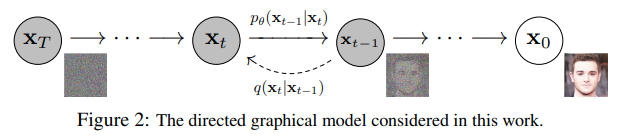

Ambos os processos direto e reverso indexados por $t$ ocorrem durante um número finito de passos de tempo $T$ (no DDPM usam $T=1000$). Começamos com $t=0$, onde se amostra uma imagem real $\mathbf{x}_0$ da distribuição de dados (digamos uma imagem de um gato), e o processo direto mostra algum ruído de uma distribuição Gaussiana em cada passo de tempo $t$, que é adicionado à imagem do passo anterior. Dado um $T$ suficientemente grande e um cronograma bem comportado para adicionar ruído em cada passo de tempo, terminamos com o que é chamado de [distribuição Gaussiana isotrópica](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic) em $t=T$ através de um processo gradual.

## A matemática por trás

Vamos escrever isso de forma mais formal, pois, em última análise, precisamos de uma função de perda tratável que nossa rede neural precisa otimizar.

Seja $q(\mathbf{x}_0)$ a distribuição de dados reais, digamos de "imagens reais". Podemos amostrar desta distribuição para obter uma imagem, $\mathbf{x}_0 \sim q(\mathbf{x}_0)$. Definimos o processo de difusão direta $q(\mathbf{x}_t | \mathbf{x}_{t-1})$ que adiciona ruído Gaussiano em cada passo de tempo $t$, de acordo com um cronograma de variância conhecido $0 < \beta_1 < \beta_2 < ... < \beta_T < 1$ como
$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}). 
$$

Uma distribuição Gaussiana é definida por dois parâmetros: uma média $\mu$ e uma variância $\sigma^2 \geq 0$. Basicamente, cada nova imagem (ligeiramente mais ruidosa) no passo de tempo $t$ é desenhada de uma **distribuição Gaussiana condicional** com $\mathbf{\mu}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1}$ e $\sigma^2_t = \beta_t$, que podemos fazer ao amostrar $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ e definir $\mathbf{x}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +  \sqrt{\beta_t} \mathbf{\epsilon}$. 

Os $\beta_t$ não são constantes em cada passo de tempo $t$ (daí o subscrito) — de fato, define-se um **"cronograma de variância"**, que pode ser linear, quadrático, cosseno, etc.

Assim, começando com $\mathbf{x}_0$, terminamos com $\mathbf{x}_1,  ..., \mathbf{x}_t, ..., \mathbf{x}_T$, onde $\mathbf{x}_T$ é ruido Gaussiano puro se definirmos o cronograma adequadamente.

Agora, se conhecessemos a distribuição condicional $p(\mathbf{x}_{t-1} | \mathbf{x}_t)$, então poderíamos executar o processo em reverso: amostrando algum ruído Gaussiano aleatório $\mathbf{x}_T$, e então ir "removendo o ruído" gradualmente para acabar com uma amostra da distribuição real $\mathbf{x}_0$.

No entanto, não conhecemos $p(\mathbf{x}_{t-1} | \mathbf{x}_t)$. É intratável, pois requer conhecer a distribuição de todas as possíveis imagens para calcular esta probabilidade condicional. Portanto, vamos aproveitar uma rede neural para aproximar (aprender) esta distribuição de probabilidade condicional, que chamaremos de $p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t)$, com $\theta$ sendo os parâmetros da rede neural, atualizados por descida de gradiente. 

Então, precisamos de uma rede neural para representar uma distribuição de probabilidade (condicional) do processo reverso. Se assumirmos que este processo reverso também é Gaussiano, então, recorde-se que qualquer distribuição Gaussiana é definida por dois parâmetros:
* uma média parametrizada por $\mu_\theta$;
* uma variância parametrizada por $\Sigma_\theta$;

então podemos parametrizar o processo como 
$$ p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t))$$
onde a média e a variância também são condicionadas ao nível de ruído $t$.


Portanto, a nossa rede neural precisa de aprender/representar a média e a variância. No entanto, os autores do DDPM decidiram **manter a variância fixa e deixar a rede neural aprender (representar) apenas a média $\mu_\theta$ desta distribuição de probabilidade condicional**. No artigo:

> Primeiro, definimos $\Sigma_\theta ( \mathbf{x}_t, t) = \sigma^2_t \mathbf{I}$ como constantes dependentes do tempo não treinadas. Experimentalmente, tanto $\sigma^2_t = \beta_t$ como $\sigma^2_t  = \tilde{\beta}_t$ (ver artigo) tiveram resultados semelhantes.

Isto foi posteriormente melhorado no artigo [Improved diffusion models](https://openreview.net/pdf?id=-NEXDKk8gZ), onde uma rede neural também aprende a variância deste processo reverso, além da média.

Assim, continuamos assumindo que a nossa rede neural apenas precisa de aprender/representar a média desta distribuição de probabilidade condicional.

## Definindo uma função objetivo (reparametrizando a média)

Para derivar uma função objetivo para aprender a média do processo reverso, os autores observaram que a combinação de $q$ e $p_\theta$ pode ser vista como um auto-encoder variacional (VAE) [(Kingma et al., 2013)](https://arxiv.org/abs/1312.6114). Portanto, o **limite inferior variacional** (também chamado de ELBO) pode ser usado para minimizar a log-verossimilhança negativa em relação à amostra de dados verdadeira $\mathbf{x}_0$ (remetemos para o artigo do VAE para detalhes sobre o ELBO). Verifica-se que o ELBO para este processo é uma soma de perdas em cada passo de tempo $t$, $L = L_0 + L_1 + ... + L_T$. Por construção do processo direto $q$ e do processo reverso, cada termo (exceto $L_0$) da perda é na verdade a **divergência KL entre 2 distribuições Gaussianas**, que pode ser escrita explicitamente como uma perda L2 em relação às médias!

Uma consequência direta do processo direto construído $q$, como mostrado por Sohl-Dickstein et al., é que podemos amostrar $\mathbf{x}_t$ em qualquer nível arbitrário de ruído condicionado em $\mathbf{x}_0$ (uma vez que a soma de Gaussianas é também Gaussiana). Isto é muito conveniente: não precisamos de aplicar $q$ repetidamente para amostrar $\mathbf{x}_t$. 
Temos que 
$$q(\mathbf{x}_t | \mathbf{x}_0) = \cal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1- \bar{\alpha}_t) \mathbf{I})$$

com $\alpha_t := 1 - \beta_t$ e $\bar{\alpha}_t := \Pi_{s=1}^{t} \alpha_s$. Vamos referir-nos a esta equação como a "propriedade agradável". Isto significa que podemos amostrar ruído Gaussiano, escalá-lo adequadamente e adicioná-lo a $\mathbf{x}_0$ para obter $\mathbf{x}_t$ diretamente. Note que $\bar{\alpha}_t$ são funções do cronograma de variância $\beta_t$ conhecido e, portanto, são também conhecidas e podem ser pré-computadas. Isto permite-nos, durante o treino, **otimizar termos aleatórios da função de perda $L$** (ou, por outras palavras, amostrar aleatoriamente $t$ durante o treino e otimizar $L_t$).


Outra vantagem desta propriedade, como mostrado por Ho et al., é que podemos (após alguns cálculos, para os quais remetemos o leitor para [este excelente post no blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)) **reparametrizar a média para que a rede neural aprenda (preveja) o ruído adicionado (através de uma rede $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$ para o nível de ruído $t$** nos termos de KL que constituem as perdas. Isto significa que a nossa rede neural se torna um preditor de ruído, em vez de um preditor de média (direta). A média pode ser calculada da seguinte forma:

$$ \mathbf{\mu}_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(  \mathbf{x}_t - \frac{\beta_t}{\sqrt{1- \bar{\alpha}_t}} \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \right)$$

A função objetivo final $L_t$ tem então a seguinte aparência (para um passo de tempo aleatório $t$ dado $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$):

$$ \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \|^2 = \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta( \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{(1- \bar{\alpha}_t)} \mathbf{\epsilon}, t) \|^2.$$

Aqui, \$\mathbf{x}_0\$ é a imagem inicial (real, não corrompida), e vemos o nível de ruído direto \$t\$ amostrado pelo processo de avanço fixo. \$\mathbf{\epsilon}\$ é o ruído puro amostrado no passo de tempo \$t\$, e \$\mathbf{\epsilon}_\theta (\mathbf{x}_t, t)\$ é a nossa rede neural. A rede neural é otimizada usando um simples erro quadrático médio (MSE) entre o ruído Gaussiano verdadeiro e o previsto.

O algoritmo de treino agora é o seguinte:

<p align="center">
    <img src="https://drive.google.com/uc?id=1LJsdkZ3i1J32lmi9ONMqKFg5LMtpSfT4" width="400" />
</p>

Em outras palavras:
* pegamos uma amostra aleatória $\mathbf{x}_0$ da distribuição de dados real, desconhecida e possivelmente complexa $q(\mathbf{x}_0)$
* amostramos um nível de ruído $t$ uniformemente entre 1 e T (ou seja, um passo de tempo aleatório)
* amostramos algum ruído de uma distribuição Gaussiana e corrompemos a entrada por este ruído no nível $t$ usando a propriedade definida acima
* a rede neural é treinada para prever este ruído com base na imagem corrompida $\mathbf{x}_t$, ou seja, ruído aplicado em $\mathbf{x}_0$ com base no cronograma conhecido $\beta_t$

Na realidade, tudo isso é feito em lotes de dados, pois usa-se o gradiente descendente estocástico para otimizar redes neurais.

## A rede neural

A rede neural precisa receber uma imagem com ruído em um determinado passo de tempo e retornar o ruído previsto. Note que o ruído previsto é um tensor que tem o mesmo tamanho/resolução que a imagem de entrada. Portanto, tecnicamente, a rede recebe e gera tensores de mesma forma. Que tipo de rede neural podemos usar para isso?

O que é tipicamente usado aqui é muito semelhante ao de um [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder), que você pode lembrar de tutoriais típicos de "introdução ao deep learning". Autoencoders têm uma camada chamada "gargalo" entre o codificador e o decodificador. O codificador primeiro codifica uma imagem em uma representação oculta menor chamada "gargalo", e o decodificador então decodifica essa representação oculta de volta em uma imagem real. Isso força a rede a manter apenas as informações mais importantes na camada de gargalo.

Em termos de arquitetura, os autores do DDPM optaram por um **U-Net**, introduzido por ([Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)) (que, na época, alcançou resultados de ponta na segmentação de imagens médicas). Esta rede, como qualquer autoencoder, consiste em um gargalo no meio que garante que a rede aprenda apenas as informações mais importantes. Importante, introduziu conexões residuais entre o codificador e o decodificador, melhorando significativamente o fluxo de gradiente (inspirado pelo ResNet em [He et al., 2015](https://arxiv.org/abs/1512.03385)).

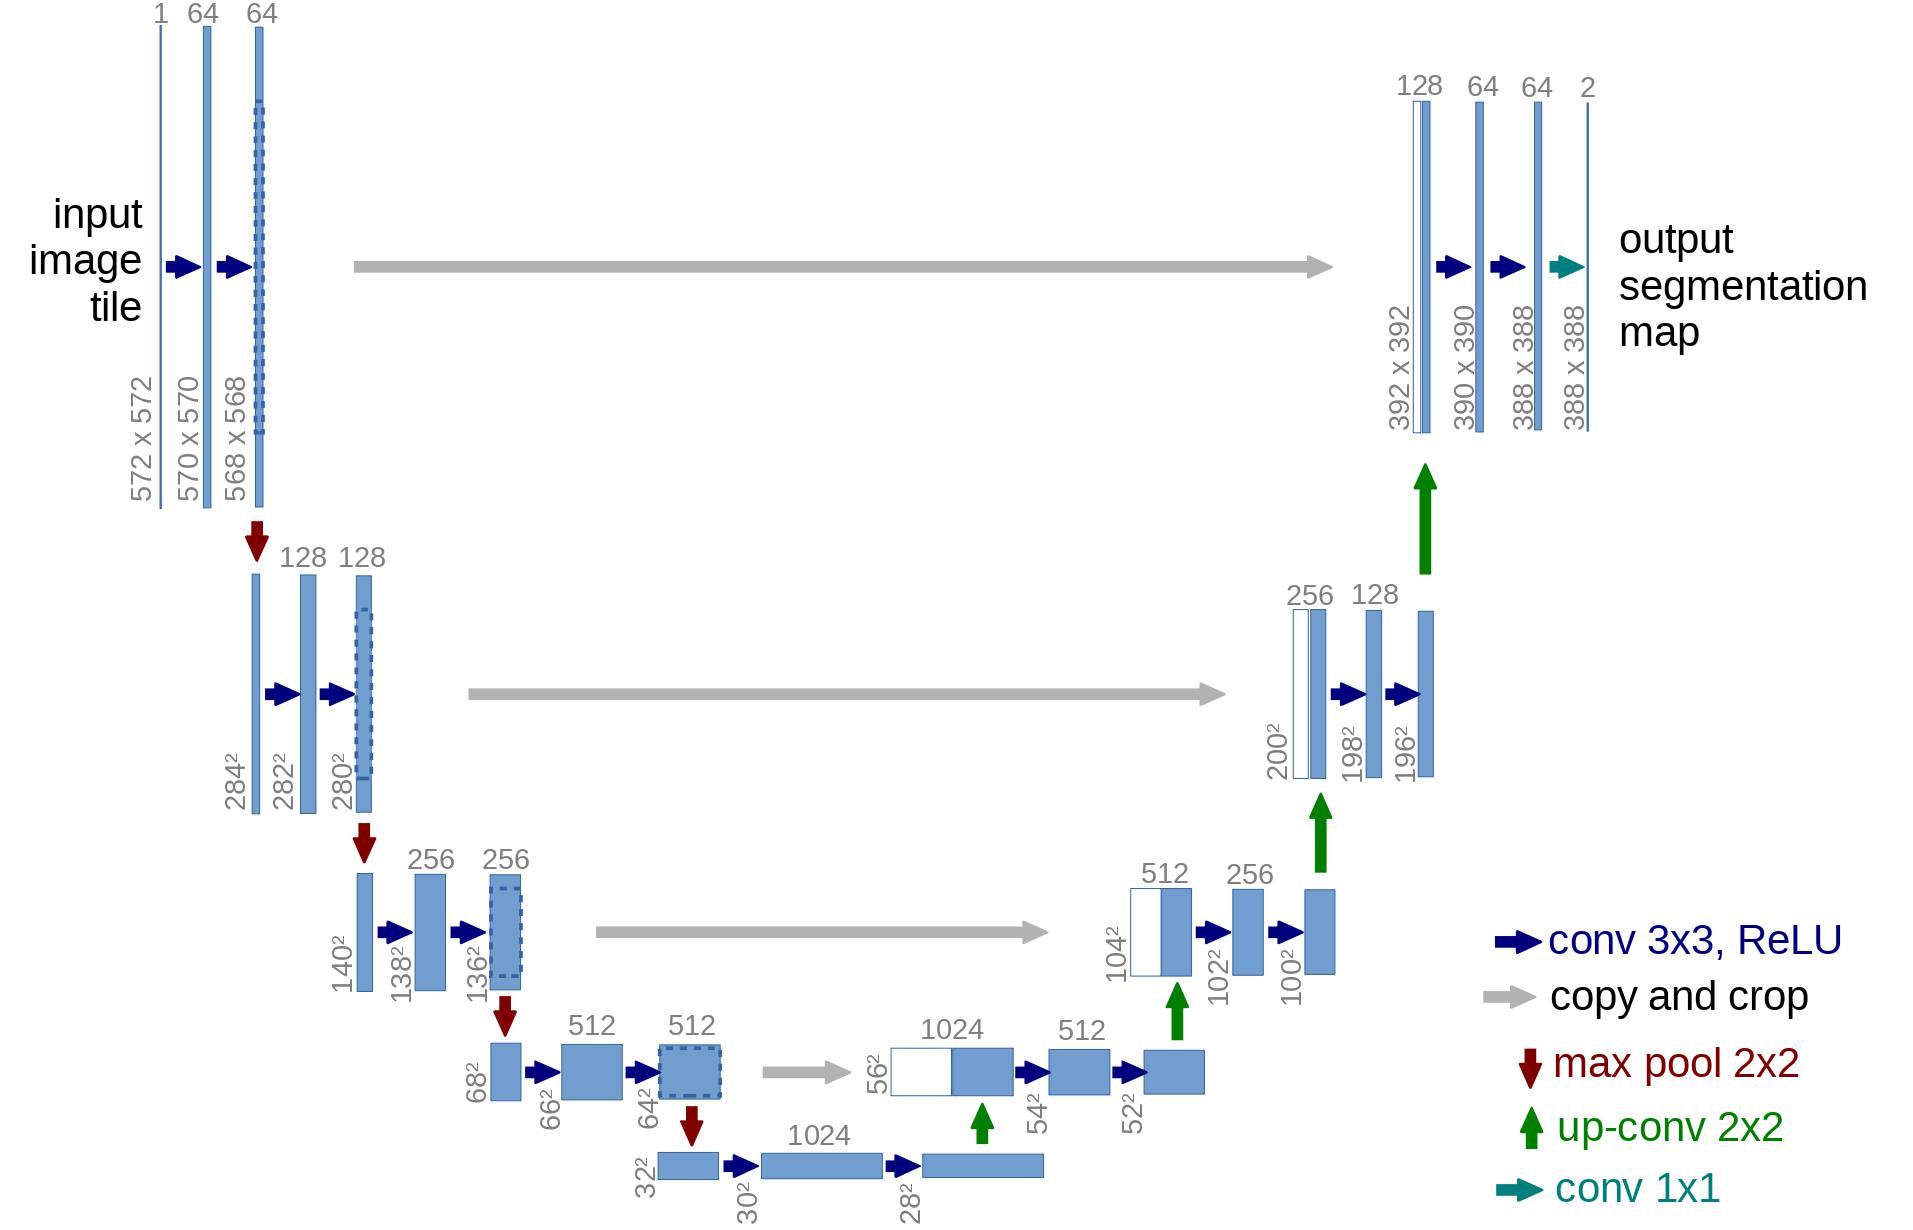

Como pode ser visto, um modelo U-Net primeiro reduz a resolução espacial da entrada, após o que é realizado o aumento da resolução.

Abaixo, implementamos esta rede, passo a passo.

### Auxiliares da Rede

Primeiro, definimos algumas funções e classes auxiliares que serão usadas na implementação da rede neural. Importante, definimos um módulo `Residual`, que simplesmente adiciona a entrada à saída de uma função particular (em outras palavras, adiciona uma conexão residual a uma função particular).

Também definimos aliases para as operações de aumento e redução de resolução.

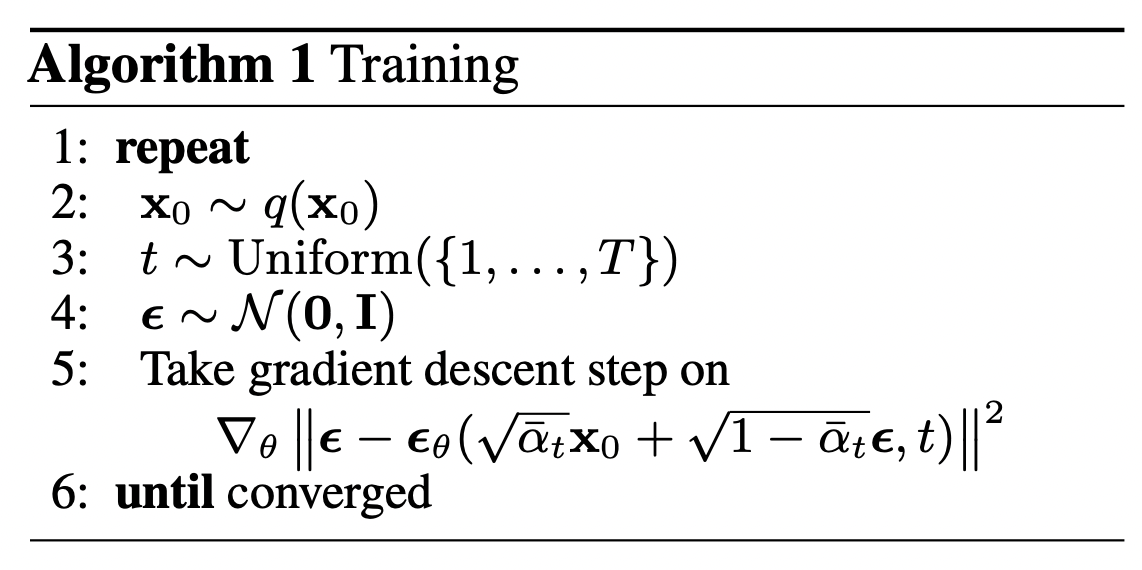

In [7]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Positional embeddings

Como os parâmetros da rede neural são compartilhados ao longo do tempo (nível de ruído), os autores utilizam embeddings posicionales senoidais para codificar \$t\$, inspirados pelo Transformer ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)). Isso faz com que a rede neural "saiba" em qual passo de tempo específico (nível de ruído) ela está operando, para cada imagem em um lote.

O módulo `SinusoidalPositionEmbeddings` recebe um tensor de forma `(batch_size, 1)` como entrada (ou seja, os níveis de ruído de várias imagens ruidosas em um lote) e transforma isso em um tensor de forma `(batch_size, dim)`, com `dim` sendo a dimensionalidade dos embeddings posicionales. Isso é então adicionado a cada bloco residual, como veremos adiante.


In [8]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### Bloco ResNet/ConvNeXT

Em seguida, definimos o bloco principal do modelo U-Net. Os autores do DDPM empregaram um bloco Wide ResNet ([Zagoruyko et al., 2016](https://arxiv.org/abs/1605.07146)), mas Phil Wang decidiu também adicionar suporte para um bloco ConvNeXT ([Liu et al., 2022](https://arxiv.org/abs/2201.03545)), pois este último teve grande sucesso no domínio da imagem. Pode-se escolher um ou outro na arquitetura final do U-Net.


In [9]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

### Módulo de atenção

Em seguida, definimos o módulo de atenção, que os autores do DDPM adicionaram entre os blocos convolucionais. A atenção é o bloco de construção da famosa arquitetura Transformer ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)), que teve grande sucesso em vários domínios da IA, desde PLN e visão até [dobramento de proteínas](https://www.deepmind.com/blog/alphafold-a-solution-to-a-50-year-old-grand-challenge-in-biology). Phil Wang emprega 2 variantes de atenção: uma é a auto-atenção multi-cabeças regular (como usada no Transformer), a outra é uma [variante de atenção linear](https://github.com/lucidrains/linear-attention-transformer) ([Shen et al., 2018](https://arxiv.org/abs/1812.01243)), cujos requisitos de tempo e memória escalam linearmente no comprimento da sequência, em oposição a quadrático para a atenção regular.

Para uma explicação extensa do mecanismo de atenção, referimos o leitor ao [maravilhoso post no blog](https://jalammar.github.io/illustrated-transformer/) de Jay Allamar.


In [10]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Normalização de grupo

Os autores do DDPM intercalam as camadas convolucionais/atenção do U-Net com normalização de grupo ([Wu et al., 2018](https://arxiv.org/abs/1803.08494)). Abaixo, definimos uma classe `PreNorm`, que será usada para aplicar a normalização de grupo antes da camada de atenção, como veremos adiante. Note que há um [debate](https://tnq177.github.io/data/transformers_without_tears.pdf) sobre se deve-se aplicar a normalização antes ou depois da atenção em Transformers.


In [11]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### U-Net condicional

Agora que definimos todos os blocos de construção (embeddings posicionales, blocos ResNet/ConvNeXT, atenção e normalização de grupo), é hora de definir toda a rede neural. Lembre-se de que o trabalho da rede \$\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)\$ é receber um lote de imagens ruidosas + níveis de ruído e retornar o ruído adicionado à entrada. Mais formalmente:

- a rede recebe um lote de imagens ruidosas de forma `(batch_size, num_channels, height, width)` e um lote de níveis de ruído de forma `(batch_size, 1)` como entrada, e retorna um tensor de forma `(batch_size, num_channels, height, width)`

A rede é construída da seguinte forma:
* primeiro, uma camada convolucional é aplicada no lote de imagens ruidosas, e embeddings posicionales são calculados para os níveis de ruído
* em seguida, uma sequência de estágios de redução de resolução é aplicada. Cada estágio de redução de resolução consiste em 2 blocos ResNet/ConvNeXT + normalização de grupo + atenção + conexão residual + uma operação de redução de resolução
* no meio da rede, novamente são aplicados blocos ResNet ou ConvNeXT, intercalados com atenção
* em seguida, uma sequência de estágios de aumento de resolução é aplicada. Cada estágio de aumento de resolução consiste em 2 blocos ResNet/ConvNeXT + normalização de grupo + atenção + conexão residual + uma operação de aumento de resolução
* finalmente, um bloco ResNet/ConvNeXT seguido de uma camada convolucional é aplicado.

Em última análise, redes neurais empilham camadas como se fossem blocos de lego (mas é importante [entender como elas funcionam](http://karpathy.github.io/2019/04/25/recipe/)).


In [12]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## Definindo o processo de difusão direta

O processo de difusão direta adiciona gradualmente ruído a uma imagem da distribuição real, em um número de passos de tempo $T$. Isso acontece de acordo com um **cronograma de variância**. Os autores originais do DDPM empregaram um cronograma linear:

> Definimos as variâncias do processo direto como constantes aumentando linearmente de $\beta_1 = 10^{−4}$ para $\beta_T = 0.02$.

No entanto, foi mostrado em ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672)) que melhores resultados podem ser alcançados ao empregar um cronograma cosseno.

Abaixo, definimos vários cronogramas para os $T$ passos de tempo, bem como as variáveis correspondentes que precisaremos, como variâncias cumulativas.


In [13]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

Para começar, vamos usar o cronograma linear para \$T=200\$ passos de tempo e definir as várias variáveis a partir de \$\beta_t\$ que precisaremos, como o produto cumulativo das variâncias \$\bar{\alpha}_t\$. Cada uma das variáveis abaixo são apenas tensores unidimensionais, armazenando valores de \$t\$ para \$T\$. Importante, também definimos uma função `extract`, que nos permitirá extrair o índice \$t\$ apropriado para um lote de índices.


In [14]:
timesteps = 1000

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

Vamos ilustrar com uma imagem dum gato como o ruído é adicionado em cada passo do processo de difusão.


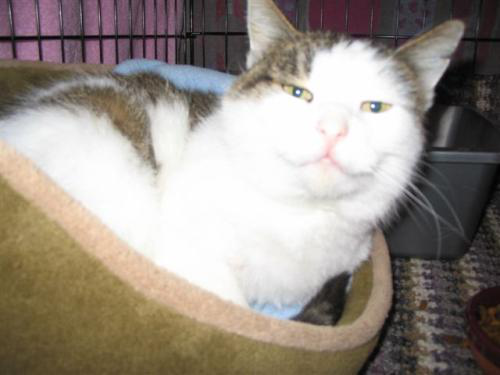

In [15]:
from PIL import Image
import requests

path = 'data\cats\986.jpg'
image = Image.open(path)
image

O ruído é adicionado a tensores PyTorch, em vez de Imagens Pillow. Primeiro, definiremos transformações de imagem que nos permitam ir de uma imagem PIL para um tensor PyTorch (sobre o qual podemos adicionar o ruído) e vice-versa.

Essas transformações são bastante simples: primeiro normalizamos as imagens dividindo por 255 (de modo que estejam na faixa $[0,1]$), e depois garantimos que estejam na faixa $[-1, 1]$. Do artigo do DDPM:

> Assumimos que os dados da imagem consistem em inteiros em $\{0, 1, ... , 255\}$ escalados linearmente para $[-1, 1]$. Isso garante que o processo reverso da rede neural opere em entradas consistentemente escaladas, começando do priore normal padrão $p(\mathbf{x}_T )$.

In [16]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
    
])

x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

<div class="output stream stdout">

    Saída:
    ----------------------------------------------------------------------------------------------------
    torch.Size([1, 3, 128, 128])

</div>

Também definimos a transformação inversa, que recebe um tensor PyTorch contendo valores em $[-1, 1]$ e os transforma de volta em uma imagem PIL:


In [17]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

Vamos verificar isso:

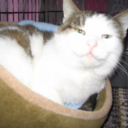

In [18]:
reverse_transform(x_start.squeeze())

Agora podemos definir o processo de difusão direta conforme no artigo:


In [19]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [20]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

Vamos testá-lo em um passo de tempo específico:


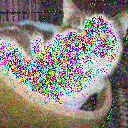

In [21]:
# take time step
t = torch.tensor([50])

get_noisy_image(x_start, t)

Vamos visualizar isso para vários passos de tempo:


In [22]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [23]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 30, 50,70, 100,500,999]])


Isso significa que agora podemos definir a função de perda dada o modelo da seguinte forma:



In [24]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

O `denoise_model` será nosso U-Net definido acima. Empregaremos a perda de Huber entre o verdadeiro e o ruído previsto.

## Define a PyTorch Dataset + DataLoader

Aqui definimos um [PyTorch Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) regular. O conjunto de dados consiste simplesmente em imagens de um conjunto de dados real, como Fashion-MNIST, CIFAR-10 ou ImageNet, escaladas linearmente para \$[−1, 1]\$.

Cada imagem é redimensionada para o mesmo tamanho. Interessante notar é que as imagens também são espelhadas horizontalmente aleatoriamente. Do artigo:

> Usamos inversões horizontais aleatórias durante o treinamento para o CIFAR10; tentamos treinar com e sem inversões, e descobrimos que as inversões melhoraram ligeiramente a qualidade da amostra.

Aqui usamos a biblioteca 🤗 [Datasets](https://huggingface.co/docs/datasets/index) para carregar facilmente o conjunto de dados Fashion MNIST do [hub](https://huggingface.co/datasets/fashion_mnist). Este conjunto de dados consiste em imagens que já têm a mesma resolução, ou seja, 28x28.

Em seguida, definimos uma função que aplicaremos em tempo real em todo o conjunto de dados. Usamos a funcionalidade `with_transform` [aqui](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Dataset.with_transform). A função simplesmente aplica alguma pré-processamento básico de imagem: inversões horizontais aleatórias, redimensionamento e finalmente faz com que tenham valores na faixa $[-1,1]$.


In [25]:
from datasets import load_dataset

#dataset = load_dataset("sampath017/plants")
#dataset = load_dataset("tpremoli/CelebA-attrs") 
#dataset = load_dataset("mnist")
#dataset = load_dataset("fashion_mnist")
#dataset = load_dataset("cifar10")
#dataset = load_dataset("keremberke/indoor-scene-classification","mini")
#dataset = load_dataset("Xenova/quickdraw-small")
#dataset = load_dataset("quickdraw","")
#dataset = load_dataset("spongus/milly-images")
#dataset = load_dataset("miladfa7/Rice-Image-Dataset")
#dataset = load_dataset("svhn",'cropped_digits')
#dataset = load_dataset("imageomics/Curated_GoldStandard_Hoyal_Cuthill")
#dataset = load_dataset("Bingsu/Cat_and_Dog")
dataset = load_dataset("gorar/A-MNIST")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [26]:

image_size = 28
channels = 1 # Cinza, mudar para 3 quando trabalhar com imagens no rgb
batch_size = 128 # Tamanho das divisoes do dataset, significa o numero de
#imagens que treinam o modelo por ciclo, quando maior mais memoria da fpu ou memeoria ram (se usar cpu) vai ser preciso

In [27]:
# Mudar a label caso necessario
""" dataset = dataset.rename_column("img","image") """

' dataset = dataset.rename_column("img","image") '

In [28]:
# Para multi-class-image datasets podemos selecionar a classe que quisermos,
# ou usá-las todas
""" 
# CIFAR-10 classes
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
bingsu_classes = [
    "dog","cat"
]

# Filtra o dataset para obter só as linhas onde a 'label' é "cat" por exemplo
def filter_cat(example):
    return bingsu_classes[example['labels']] == "cat"

dataset = dataset.filter(filter_cat)

print(dataset)
 """


' \n# CIFAR-10 classes\ncifar10_classes = [\n    "airplane", "automobile", "bird", "cat", "deer",\n    "dog", "frog", "horse", "ship", "truck"\n]\nbingsu_classes = [\n    "dog","cat"\n]\n\n# Filtra o dataset para obter só as linhas onde a \'label\' é "cat" por exemplo\ndef filter_cat(example):\n    return bingsu_classes[example[\'labels\']] == "cat"\n\ndataset = dataset.filter(filter_cat)\n\nprint(dataset)\n '

In [29]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
# algumas das transfomrções só são precisas se estiver:
# 1 a trabalhar com imagens de tamanhos irregulares do dataset
# e/ou
# 2 a trabalhar com imagens com todas as cores (rgb)
transform = Compose([ 
            #transforms.Resize((image_size,image_size)), # 1
            #Resize(image_size), # 1
            #CenterCrop(image_size), # 1
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1),
            #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 2
           
])

# função para das transformações 
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.select_columns("image").with_transform(transforms)

# criamos o dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)


In [30]:
print(transformed_dataset["train"])

Dataset({
    features: ['image'],
    num_rows: 120000
})


In [31]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


In [32]:
print(dataloader)

## Amostragem

Como vamos amostrar do modelo durante o treinamento (para acompanhar o progresso), definimos o código para isso abaixo. A amostragem é resumida no artigo como Algoritmo 2:

<img src="https://drive.google.com/uc?id=1ij80f8TNBDzpKtqHjk_sh8o5aby3lmD7" width="500" />

Gerar novas imagens a partir de um modelo de difusão acontece revertendo o processo de difusão: começamos em $T$, onde amostramos ruído puro de uma distribuição gaussiana, e então usamos nossa rede neural para gradualmente desnoisá-lo (usando a probabilidade condicional que ela aprendeu), até chegarmos ao passo de tempo $t = 0$. Como mostrado acima, podemos derivar uma imagem um pouco menos desnoisada $\mathbf{x}_{t-1 }$ ao inserir a reparametrização da média, usando nosso preditor de ruído. Lembre-se de que a variância é conhecida antecipadamente.

Idealmente, acabamos com uma imagem que parece ter vindo da distribuição de dados reais.

O código abaixo implementa isso.

Nota: O código é uma versão simplificada da implementação original. Descobrimos que nossa simplificação (que está alinhada com o Algoritmo 2 no artigo) funciona tão bem quanto a [implementação original, mais complexa](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/diffusion_utils.py).


In [33]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

## Treine o modelo

Em seguida, treinamos o modelo da maneira regular do PyTorch. Também definimos alguma lógica para salvar periodicamente imagens geradas, usando o método `sample` definido acima.


In [34]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

Abaixo, definimos o modelo e o movemos para a GPU. Também definimos um otimizador padrão (Adam).


In [35]:
from torch.optim import Adam

device =  torch.device('cuda') # Mudar para cpu caso não tenha gpu capaz da tarefa

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

Vamos começar a treinar

In [36]:
from torchvision.utils import save_image

epochs = 10
global_step = 0
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")
      loss.backward()
      optimizer.step()

      # save generated images
      if global_step != 0 and global_step % save_and_sample_every == 0:
        milestone = global_step //save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = torch.tensor(list(map(lambda n: sample(model,image_size=image_size, batch_size=n, channels=channels), batches)))
        all_images = torch.cat([img for sublist in all_images_list for img in sublist], dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
      global_step +=1
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    print(global_step)

# Avisa quando terminar

notification.notify(
    title='Treinamento Concluído',
    message='O treinamento do modelo foi concluído com sucesso.',
    app_name='Modelo de Treinamento',
    timeout=10  
)

c:\ProgramData\anaconda3\envs\tde\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/10], Loss: 0.0110
938


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\moham\AppData\Local\Temp\ipykernel_25804\3080229368.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  all_images_list = torch.tensor(list(map(lambda n: sample(model,image_size=image_size, batch_size=n, channels=channels), batches)))


Epoch [2/10], Loss: 0.0130
1876


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.0107
2814


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0130
3752


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0139
4690


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0129
5628


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0143
6566


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0110
7504


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0095
8442


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0101
9380


## Amostragem (inferência)

Para amostrar do modelo, podemos usar apenas nossa função de amostragem definida acima:


In [37]:
# sample images
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

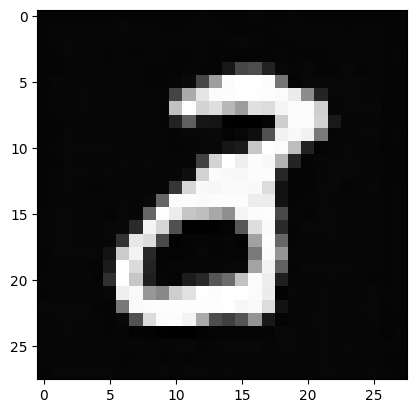

In [38]:
import random
# show a random one
random_index =random.randint(0, batch_size-1)
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels),cmap="gray")

Parece que o modelo é capaz de gerar uma camiseta legal! Tenha em mente que o conjunto de dados no qual treinamos é de baixa resolução (28x28).


Também podemos criar um gif do processo de desnoisamento:






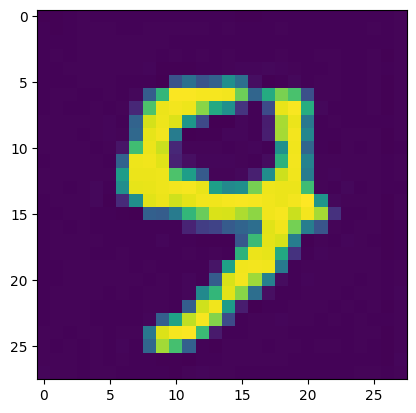

In [39]:
import matplotlib.animation as animation
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML
import numpy as np

random_index = 28

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=75, blit=True, repeat_delay=1000)

# Salva a animação como um arquivo GIF
ani.save('animation.gif', writer='pillow')

# Exibe a animação no notebook
display(HTML(ani.to_html5_video()))  

@article{
    ho2020denoising,
    title={Denoising Diffusion Probabilistic Models},
    author={Jonathan Ho and Ajay Jain and Pieter Abbeel},
    year={2020},
    journal={arXiv preprint arxiv:2006.11239}
}
